<a href="https://colab.research.google.com/github/HarisJafri-xcode/marketing-ab-testing-ctr-analysis/blob/main/marketing_ab_testing_ctr_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Problem

The Marketing Team of a company wants to evaluate the effectiveness of two different advertising campaigns featuring two brand ambassadors — **Babar Azam** and **Mahira Khan**.  

Each version of the advertisement was shown to a separate group of users under similar conditions.  
The goal is to determine whether the difference in the **Click-Through Rates (CTR)** of the two ads is **statistically significant** or simply due to random variation.

- **Business Objective:** Determine whether the CTR for Ad Babar and Ad Mahira **differs** or not.
- **Data Provided:** User-level data including ad version, whether the user clicked or not, and demographic details such as device type, region, gender, and age group.  
- **Analytical Approach:** Perform **A/B Testing** to statistically test if there is a significant difference between the CTRs of Ad Babar and Ad Mahira.  

**Key Question:**  
> “Is there enough statistical evidence to conclude that Babar Ads performs different than Mahira Ads in terms of CTR?”

# Importing Libraries and Data Set

Let us import all the relevant general libraries first, which we believe are of use to perform A/B Testing.

Any additional Library can be imported at a Later Stage.

In [9]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

Let us import the Data Set and store it inside the Variable "df".

In [10]:
file_path = 'https://raw.githubusercontent.com/HarisJafri-xcode/marketing-ab-testing-ctr-analysis/main/ads_ctr_data.csv'
df = pd.read_csv(file_path)

# Exploratory Data Analysis

## Data Structure Overview

In [11]:
# Number of Rows and Columns in the Data Set
df.shape

(5000, 9)

In [12]:
# Name of Columns in the Data Set
df.columns

Index(['user_id', 'ad_version', 'clicked', 'device_type', 'region', 'gender',
       'age_group', 'conversion', 'date'],
      dtype='object')

In [13]:
# Overview of the Data Structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      5000 non-null   int64 
 1   ad_version   5000 non-null   object
 2   clicked      5000 non-null   int64 
 3   device_type  5000 non-null   object
 4   region       5000 non-null   object
 5   gender       5000 non-null   object
 6   age_group    5000 non-null   object
 7   conversion   5000 non-null   int64 
 8   date         5000 non-null   object
dtypes: int64(3), object(6)
memory usage: 351.7+ KB


There are 5000 Records in the Data Set indexed from 0 to 4999.

Data Set contains 9 Columns and none of them have any Null Value. which is obvious since this Data Set is Custom Made.

Our Primary Concern is to understand the Working of A/B Testing and not Data Cleaning. Although that is also an essential skill.

Only thing that might require our attention might be "date" column that is not in "date/time" format instead is in "object" format.

Also only 3 columns are "int64" Dtype but "user_id" is not a measure.

## Summary Statistics

In [14]:
# Reviewing First 5 of the Data Set
print("First Five Rows are as follows:")
df.head(5)

First Five Rows are as follows:


,user_id,ad_version,clicked,device_type,region,gender,age_group,conversion,date
0,1,Mahira,1,Tablet,Islamabad,Male,18-24,0,9/26/2025
1,2,Mahira,0,Mobile,Islamabad,Male,25-34,0,9/16/2025
2,3,Babar,0,Mobile,Karachi,Female,35-44,0,9/14/2025
3,4,Mahira,0,Desktop,Islamabad,Male,35-44,0,9/12/2025
4,5,Mahira,0,Tablet,Islamabad,Female,25-34,0,9/14/2025


In [15]:
# Reviewing Bottom 5 of the Data Set
print("Bottom Five Rows are as follows:")
df.tail(5)

Bottom Five Rows are as follows:


,user_id,ad_version,clicked,device_type,region,gender,age_group,conversion,date
4995,4996,Mahira,0,Mobile,Islamabad,Female,18-24,0,9/12/2025
4996,4997,Mahira,1,Mobile,Lahore,Female,25-34,0,9/22/2025
4997,4998,Babar,0,Tablet,Islamabad,Male,18-24,0,9/11/2025
4998,4999,Babar,0,Mobile,Lahore,Female,35-44,0,9/8/2025
4999,5000,Babar,0,Mobile,Lahore,Male,25-34,0,9/23/2025


In [16]:
# Statistical Summary of "int64" Data Types
df[['clicked','conversion']].describe().T

,count,mean,std,min,25%,50%,75%,max
clicked,5000.0,0.1040,0.305291,0.0,0.0,0.0,0.0,1.0
conversion,5000.0,0.0242,0.153685,0.0,0.0,0.0,0.0,1.0


Let us observe how many of Users who watched the any version of the Ad actually clicked it. And how many actually converted !

In [17]:
print(np.sum(df['clicked']))

520


In [18]:
print(np.sum(df['conversion']))

121


We are sure that 'ad_version' Column only contains "Babar" and "Mahira" but lets be sure about it !

In [19]:
print(df['ad_version'].unique())

['Mahira' 'Babar']


How Many Number of Users where shown Babar Ads and How Many Number of User's were shown Mahira Ads ?

In [20]:
df['ad_version'].value_counts()

,count
ad_version,
Babar,2566
Mahira,2434


Let us store this Pandas DataSeries that inside a Variable.

In [21]:
impressions = df['ad_version'].value_counts()

In [22]:
Babar_Total_Impression = impressions['Babar']
Mahira_Total_Impression = impressions['Mahira']

In [23]:
print(Babar_Total_Impression)

2566


In [24]:
print(Mahira_Total_Impression)

2434


Same Exercise can be done for Clicked as well.

In [25]:
# Count total clicks per ad version
clicks = df.groupby('ad_version')['clicked'].sum()

# CTR calculation
Babar_Clicks = clicks['Babar']
Mahira_Clicks = clicks['Mahira']

Babar_CTR = Babar_Clicks / Babar_Total_Impression
Mahira_CTR = Mahira_Clicks / Mahira_Total_Impression

These are a lot of Variables. Let us Summarize all of that !

In [26]:
summary_data = {
    'Ad Version': ['Babar', 'Mahira'],
    'Total Impressions': [Babar_Total_Impression, Mahira_Total_Impression],
    'Total Clicks': [Babar_Clicks, Mahira_Clicks],
    'CTR (Click-Through Rate)': [Babar_CTR, Mahira_CTR]
}

summary_df = pd.DataFrame(summary_data)

summary_df['CTR (%)'] = (summary_df['CTR (Click-Through Rate)'] * 100).round(2) # Add another Column for CTR but in terms of Percentage

display(summary_df)

,Ad Version,Total Impressions,Total Clicks,CTR (Click-Through Rate),CTR (%)
0,Babar,2566,251,0.097818,9.78
1,Mahira,2434,269,0.110518,11.05


## Visual Representations

Before diving into hypothesis testing, it’s important to **visually explore** the data.  
Charts help us quickly spot patterns, differences, or anomalies between the two ad versions.  
Here we’ll visualize:
1. Total Impressions by Ad Version  
2. Total Clicks by Ad Version  
3. Click-Through Rate (CTR %) Comparison  

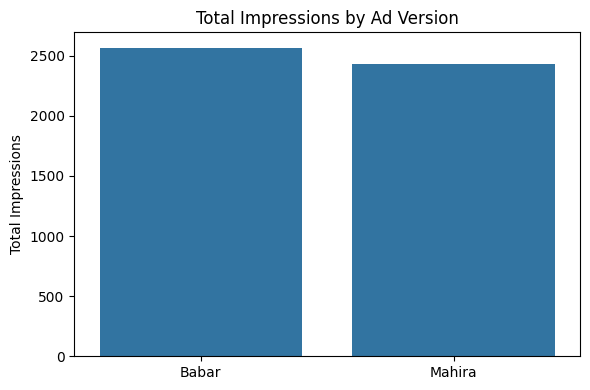

In [27]:
plt.figure(figsize=(6,4))
sns.barplot(x='Ad Version', y='Total Impressions', data=summary_df)
plt.title('Total Impressions by Ad Version')
plt.ylabel('Total Impressions')
plt.xlabel('')
plt.tight_layout()
plt.show()

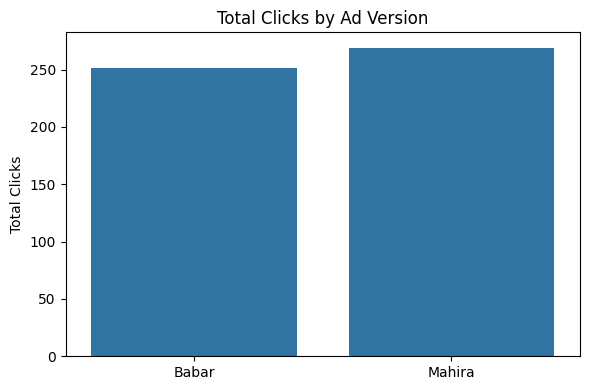

In [28]:
plt.figure(figsize=(6,4))
sns.barplot(x='Ad Version', y='Total Clicks', data=summary_df)
plt.title('Total Clicks by Ad Version')
plt.ylabel('Total Clicks')
plt.xlabel('')
plt.tight_layout()
plt.show()

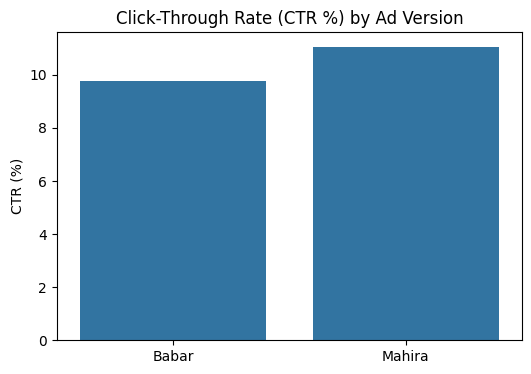

In [29]:
plt.figure(figsize=(6,4))
sns.barplot(x='Ad Version', y='CTR (%)', data=summary_df)
plt.title('Click-Through Rate (CTR %) by Ad Version')
plt.ylabel('CTR (%)')
plt.xlabel('')
plt.show()

# Formulate Hypotheses

**Null Hypothesis (H₀):** There is no difference in CTR between the two ads  

\[
H_0: p_1 = p_2
\]

**Alternative Hypothesis (H₁):** There is a difference in CTR between the two ads  
\[
H_1: p_1 != p_2
\]

**Significance Level (α):** 0.05 (5%)  

# Z-Test for Difference in Proportions

In [30]:
# Extract values from the summary table
x1 = Babar_Clicks
n1 = Babar_Total_Impression
x2 = Mahira_Clicks
n2 = Mahira_Total_Impression

# Sample Proportions
p1 = x1 / n1
p2 = x2 / n2

# Pooled Proportion
p_pool = (x1 + x2) / (n1 + n2)

# Z-statistic
z_stat = (p1 - p2) / math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))

prob = stats.norm.cdf(abs(z_stat))

# Two-tailed p-value
p_value = 2 * (1 - prob)

print(f"Probability that a standard normal variable lies below |z_stat| ({abs(z_stat):.2f}) = {prob:.4f}")
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

Probability that a standard normal variable lies below |z_stat| (1.47) = 0.9293
Z-Statistic: -1.4704
P-Value: 0.1415


# Interpretation of Results

We compare the **p-value** with the **significance level (α = 0.05)**:

- If **p-value < 0.05**, we **reject H₀** → there is a statistically significant difference in CTRs.  
- If **p-value ≥ 0.05**, we **fail to reject H₀** → there is no statistically significant difference in CTRs.

> This is a **two-tailed test**, so the computed p-value already accounts for both sides of the normal curve.

In [31]:
if p_value < 0.05:
    print("Reject Null Hypothesis: Significant difference in CTRs.")
else:
    print("Fail to Reject Null Hypothesis: No significant difference in CTRs.")

Fail to Reject Null Hypothesis: No significant difference in CTRs.


# Verification using **statsmodels**

There is an In-Built Approach to conduct the experiment without getting into the Fuss of Calculating it ourself. Let us use that for Confirmation of our Works !

In [32]:
count = np.array([x1, x2])
nobs = np.array([n1, n2])

# Perform the two-proportion Z-test
z_stat_s, p_value_s = sms.proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-Statistic (statsmodels): {z_stat_s:.4f}")
print(f"P-Value (statsmodels): {p_value_s:.4f}")

Z-Statistic (statsmodels): -1.4704
P-Value (statsmodels): 0.1415


# Business Interpretation

Even though one ad may appear to have a slightly higher CTR,  
we must rely on **statistical evidence** to decide if that difference is **real** or due to **chance**.

- If the p-value is **greater than 0.05**, the difference in CTR between Babar and Mahira’s ads is **not statistically significant**.  
- Therefore, we cannot conclude that either ad performs better — the observed difference may be due to random variation.  

This ensures that our marketing decisions are **data-driven** rather than based on intuition.

In this case, the data suggests that while one ad may seem slightly ahead, the difference is not strong enough statistically to be confident that one version truly outperforms the other.